# <center> <font style="color:rgb(100,109,254)"> Obect Detection with YOLO v3</font> </center>

In this Notebook we'll look at another detection framework called YOLO (You only look once). This network has been trained on the 80 classes of the coco dataset. This particular network provides Results at 3 different scales.

<center><img src="Media/M4/yolo_architecture.png" style= height:500px /></center>



In [3]:
# Importing Required libraries
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk 
import os
import sys

## <font style="color:rgb(134,19,348)"> Loading Class Labels </font>



In [4]:
# Split all the classes by a new line and store it in variable called rows.
CLASSES = open('Media/M4/Model/coco.names').read().strip().split("\n")

# Check the number of classes.
print("Number of Classes: {} \n".format(len(CLASSES)))

# Print the first 5 procesed class labels 
print(CLASSES)

Number of Classes: 80 

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


##  <font style="color:rgb(134,19,348)"> Read the Image </font>


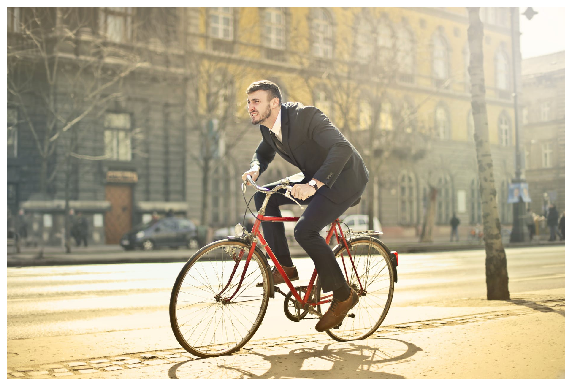

In [5]:
# Load the input image
image = cv2.imread('Media/M4/bicycle.jpeg')

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1]);plt.axis("off");

## <font style="color:rgb(134,19,348)">  Initializing the DNN Module </font>

Load the darknet YOLO model.

[```retval =cv2.dnn.readNetFromDarknet( prototxt[, Model] )```]()

**Params:**

- **`prototxt:`**	Path to the .prototxt file, this is the text description of the architecture of the model. 
- **`Model:`**	path to the .darknet model file. this is your actual trained neural network model, it contains all the weights/parameters of the model. This is usually several MBs in size.



In [10]:
# Load the Model Weights.
weights = 'Media/M4/Model/yolov3.weights'

# Load the configuration  Architecture.
architecture = 'Media/M4/Model/yolov3.cfg'

# Initialize the network.
net = cv2.dnn.readNetFromDarknet(architecture, weights)

In [11]:
# Get all layer names of the architecture.
name_of_layers = net.getLayerNames()
print('Number of layers in the network: {}'.format(len(name_of_layers)))

Number of layers in the network: 254


The 3 output layers are not connected, we can get their index with `net.getUnconnectedOutLayers()` and then use **output_layer_names** to find their names.

In [12]:
output_layer_names = [name_of_layers[idx[0]-1] for idx in net.getUnconnectedOutLayers()]
print(output_layer_names)

['yolo_82', 'yolo_94', 'yolo_106']


## <font style="color:rgb(134,19,348)"> Pre-processing the image</font>


In [13]:
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)

## <font style="color:rgb(134,19,348)"> Input the Blob Image to the Network  </font>

In [14]:
# Passing the blob as input through the network 
net.setInput(blob)

##  <font style="color:rgb(134,19,348)"> Forward Pass </font>
Perform Forward and get the output of all 3 layers.

In [17]:
%%time
Outputs = net.forward(output_layer_names)

Wall time: 713 ms


In [18]:
# Generate Random Color List
(h, w) = image.shape[:2]
COLORS = np.random.randint(50, 255, size=(len(CLASSES),3),dtype="uint8") 

##  <font style="color:rgb(134,19,348)"> Post Process the Results </font>


In [19]:
# We'll store all the bounding boxes, confidence & class_indexes here.
BOXES = []
CONF = []
CLASS_INDEX = []

conf = 0.5
# Iterate for each output layer
for output in Outputs:
    
    # Iterate for each detection in that output layer
    for detection in output:
        
        # Get the probabilities of all classes for that detection
        scores = detection[5:]  
        
        # Get the Class ID of the most likely class
        classID = np.argmax(scores)
        
        # Also get the confidence.
        confidence = scores[classID]
        
        # Make sure the confidence is above some threshold.
        if confidence > conf:
            
            # Multiply the relative coordinates with width, height to get the actual coordinates on the image. 
            box = detection[0:4] * np.array([w,h, w,h])
            
            # Convert to Int
            (centerX, centerY, width, height) = box.astype("int")
            
            # Get the x1, y1 from the center points
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            
            # Append boxes, confidence and class indexes.
            BOXES.append([x, y, int(width), int(height)])
            CONF.append(float(confidence))
            CLASS_INDEX.append(classID)

In [20]:
print("Detected Objects: {}".format(len(CLASS_INDEX)))

Detected Objects: 6


##  <font style="color:rgb(134,19,348)"> Non-Max Suppression </font>
Here we will perform non max suppression. NMS outputs a list of indexes of all valid Objects.

[```cv2.dnn.NMSBoxes(bboxes, scores, score_threshold, nms_threshold[, eta[, top_k]])```]()

**Params:**

- **`bboxes:`**	set of bounding boxes to apply NMS. 
- **`scores:`**	set of corresponding confidences.
- **`score_threshold:`** Its a threshold used to filter boxes by score.
- **`nms_threshold:`**	It's a threshold used in non maximum suppression
- **`eta`**	It's a a coefficient in adaptive threshold formula

In [23]:
NMS = cv2.dnn.NMSBoxes(BOXES, CONF, conf, 0.4)

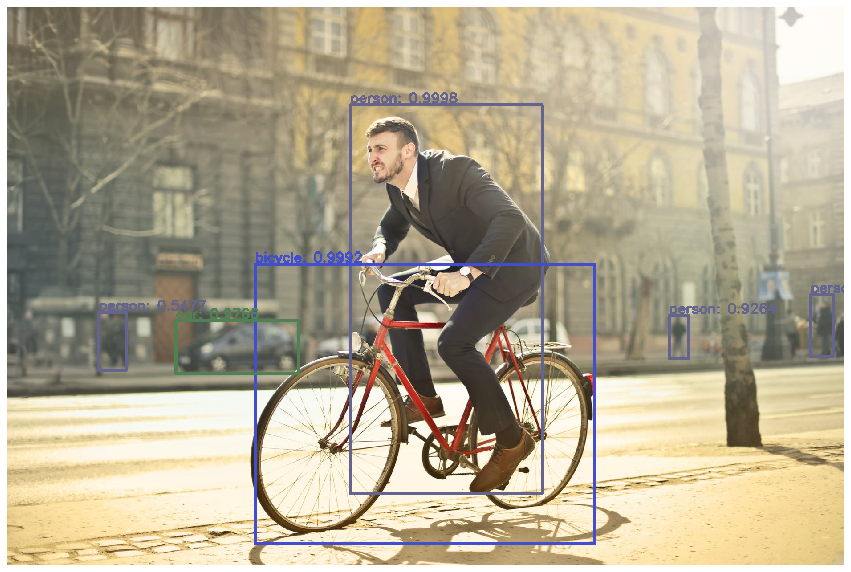

In [30]:
image_copy = image.copy()

# Proceed if detections exist.
if len(NMS) > 0:
    
    # Loop over the valid indexes 
    for i in NMS.flatten(): 
        
        # Extract the bounding box coordinates
        (X1, Y1) = (BOXES[i][0], BOXES[i][1])
        (width,height) = (BOXES[i][2], BOXES[i][3])

        # Draw a bounding box rectangle and label on the image
        color = [int(clr) for clr in COLORS[CLASS_INDEX[i]]]
        cv2.rectangle(image_copy, (X1, Y1), (X1 + width, Y1 + height), color, 6)
        
        text = "{}: {:.4f}".format(CLASSES[CLASS_INDEX[i]], CONF[i])
        cv2.putText(image_copy, text, (X1, Y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,1, color, 3)
 
 # Show the output image
plt.figure(figsize=(15,15))
plt.imshow(image_copy[:,:,::-1]);plt.axis("off");

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialize the Method </font>
This method will be run once and it will initialize the network with the required files.

In [31]:
def init_detect(usegpu = 'None',weights_name = 'yolov3.weights', architecture_name = 'yolov3.cfg'):
    
    # Set global variables
    global net,CLASSES,OUPUT_LAYERS_NAME,COLORS
    
    base_path = 'Media/M4/Model'
    
    
    # Read the Classes
    CLASSES = open(os.path.join(base_path,'coco.names')).read().strip().split("\n")
    
    COLORS = np.random.randint(100, 255, size=(len(CLASSES),3),dtype="uint8") 
    
    weights = os.path.join(base_path, weights_name)
    architecture = os.path.join(base_path, architecture_name)
    
    # Intialize the model
    net = cv2.dnn.readNetFromDarknet(architecture, weights)   
    
    
    LIST_OF_LAYERS_NAME = net.getLayerNames()

    OUPUT_LAYERS_NAME = [LIST_OF_LAYERS_NAME[index[0]-1] for index in net.getUnconnectedOutLayers()]

    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [32]:
def yolo_detect(image=[], usercam=False,returndata=False, size=2,detect_thresh=0.5,nms_thresh=0.4,annotate = True):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
        
        # Otherwise select image from computer using tkinter
        else:
            root = Tk()
            filename =  filedialog.askopenfilename(title = "Select Image")
            root.withdraw()
            image = cv2.imread(filename)

    (h, w) = image.shape[:2]        
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416,416),swapRB=True, crop=False)
    net.setInput(blob)
    Outputs = net.forward(OUPUT_LAYERS_NAME)
    
    # We'll store all the bounding boxes, confidence & class_indexes here.
    BOXES = []
    CONF = []
    CLASS_INDEX = []

    image_copy = image.copy()
    
    # Iterate for each output layer
    for output in Outputs:

        # Iterate for each detection in that output layer
        for detection in output:

            # Get the probabilities of all classes for that detection
            scores = detection[5:]  

            # Get the Class ID of the most likely class
            classID = np.argmax(scores)

            # Also get the confidence.
            confidence = scores[classID]

            # Make sure the confidence is above some threshold.
            if confidence > detect_thresh:

                # Multiply the relative coordinates with width, height to get the actual coordinates on the image. 
                box = detection[0:4] * np.array([w,h, w,h])

                # Convert to Int
                (centerX, centerY, width, height) = box.astype("int")

                # Get the x1, y1 from the center points
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # Append boxes, confidence and class indexes.
                BOXES.append([x, y, int(width), int(height)])
                CONF.append(float(confidence))
                CLASS_INDEX.append(classID)    
    
    # Here we are doing Non maximum suppresion
    NMS = cv2.dnn.NMSBoxes(BOXES, CONF, detect_thresh,nms_thresh)
    
    # Proceed if detections exist.
    if len(NMS) > 0:

        # Loop over the valid indexes 
        for i in NMS.flatten(): 

            # Extract the bounding box coordinates
            (X1, X2) = (BOXES[i][0], BOXES[i][1])
            (Y1,Y2) = (BOXES[i][2], BOXES[i][3])

            # Draw a bounding box rectangle and label on the image
            color = [int(clr) for clr in COLORS[CLASS_INDEX[i]]]
            cv2.rectangle(image_copy, (X1, X2), (X1 + Y1, X2 + Y2), color, 6)

            text = "{}: {:.4f}".format(CLASSES[CLASS_INDEX[i]], CONF[i])
            cv2.putText(image_copy, text, (X1, X2 - 5), cv2.FONT_HERSHEY_SIMPLEX,2, color, 4)
            
    if  returndata:
        return image_copy
 
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image_copy[:,:,::-1]);plt.axis("off");

**Initialize the Yolo detector**

In [33]:
init_detect()

**Calling Detector with default arguments.**

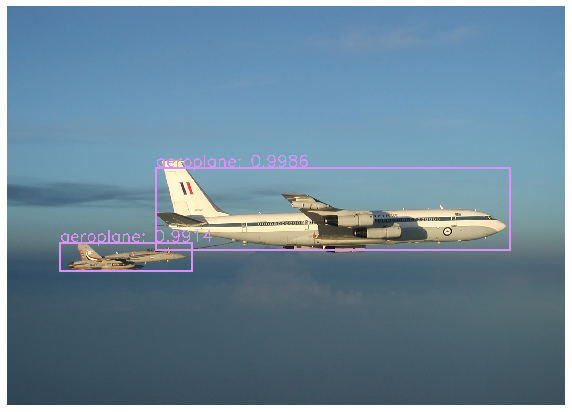

In [34]:
image = cv2.imread("Media/M4/object2.jpg")
yolo_detect(image)

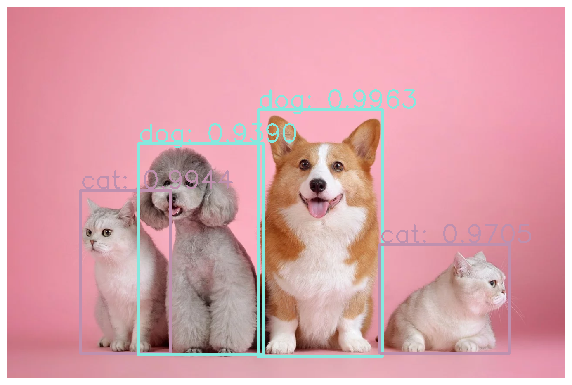

In [35]:
image = cv2.imread("Media/M4/1.png")
yolo_detect(image)

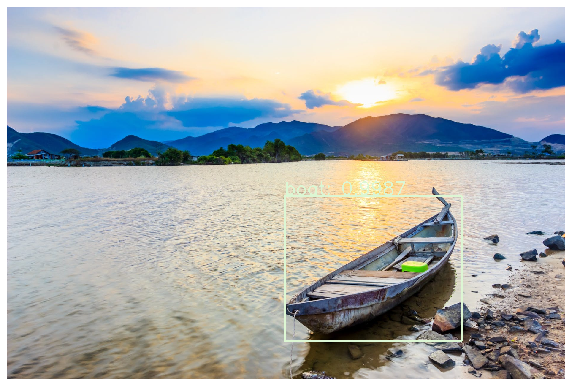

In [36]:
image = cv2.imread("Media/M4/boat.jpeg")
yolo_detect(image)

####  Capturing Image from Camera

In [ ]:
yolo_detect(usercam = True)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [ ]:
init_detect()

In [ ]:
%%time
image= yolo_detect(image = image, returndata=True)

**Intel GPU**

In [ ]:
init_detect(usegpu = 'opencl')

In [ ]:
%%time
image= yolo_detect(image = image, returndata=True)

**NVIDIA GPU**

In [ ]:
init_detect(usegpu = 'cuda')

In [ ]:
%%time
image= yolo_detect(image = image, returndata=True)

## <font style="color:rgb(134,19,348)"> Object Detection with Live Webcam </font>

In [ ]:
fps = 0
init_detect()  

cap=cv2.VideoCapture(0) 

while(True):    
    
    start_time = time.time()    
    ret, frame=cap.read() 
    if not ret:
        break
        
    image = cv2.flip(frame,1) 
    
    image = yolo_detect(image,returndata=True,size=1)
    
    cv2.putText(image, 'FPS: {:.2f}'.format(fps), (370, 20), cv2.FONT_HERSHEY_COMPLEX,0.8, (255, 20, 55), 2)
    cv2.imshow("Image",image)
    
    fps= (1.0 / (time.time() - start_time))
    k = cv2.waitKey(1)
    if k == 27:
        break
        
cap.release() 
cv2.destroyAllWindows() 